# House Predictions Again lets try this with better results..... Lets Go
## Importing Packages

### I will try Scipy this time for normalization and skewing of data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
from scipy.stats import norm, skew # For stats

### Lets Load and Analyze Data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [3]:
print("Size of Train data: {}".format(train.shape))
print("Size of Test data: {}".format(test.shape))

Size of Train data: (1460, 81)
Size of Test data: (1459, 80)


### Dropping undesired columns

In [4]:
train_id = train['Id']
test_id = test['Id']

train.drop("Id", axis=1, inplace = True)
test.drop("Id", axis=1, inplace = True)

### Handling outliers

Outliers in GrLivArea is recommended to remove by auther of the dataset. So removing any houses with more than 4000 Sq. feet

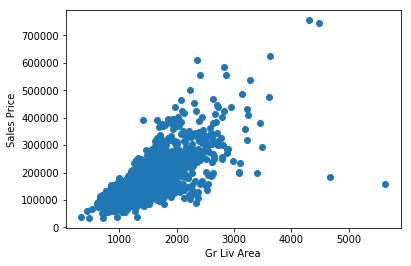

In [5]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.set(xlabel = 'Gr Liv Area', ylabel = 'Sales Price')
plt.show()

In [6]:
# Remove outliers with low price and high livarea

# Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

### Correlation Analysis


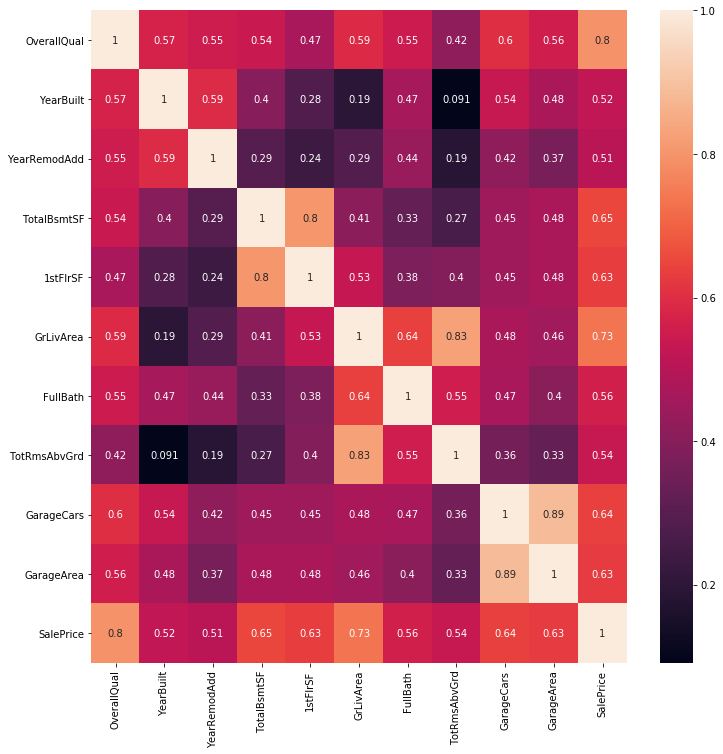

In [7]:
# Most Correlated Features

corr_mat = train.corr()
top_corr_features = corr_mat.index[abs(corr_mat["SalePrice"])>0.5]

plt.figure(figsize= (12,12))

h_map = sns.heatmap(train[top_corr_features].corr(), annot = True)

- On analysis we observe that features (OverallQual, GrLivArea, TotalBsmtSF) are highly and positively correlated with SalePrice
- So is TotRmsAbvGrd and GrLivArea
- GarageArea and GarageCars are also correlated which is kind of obvious

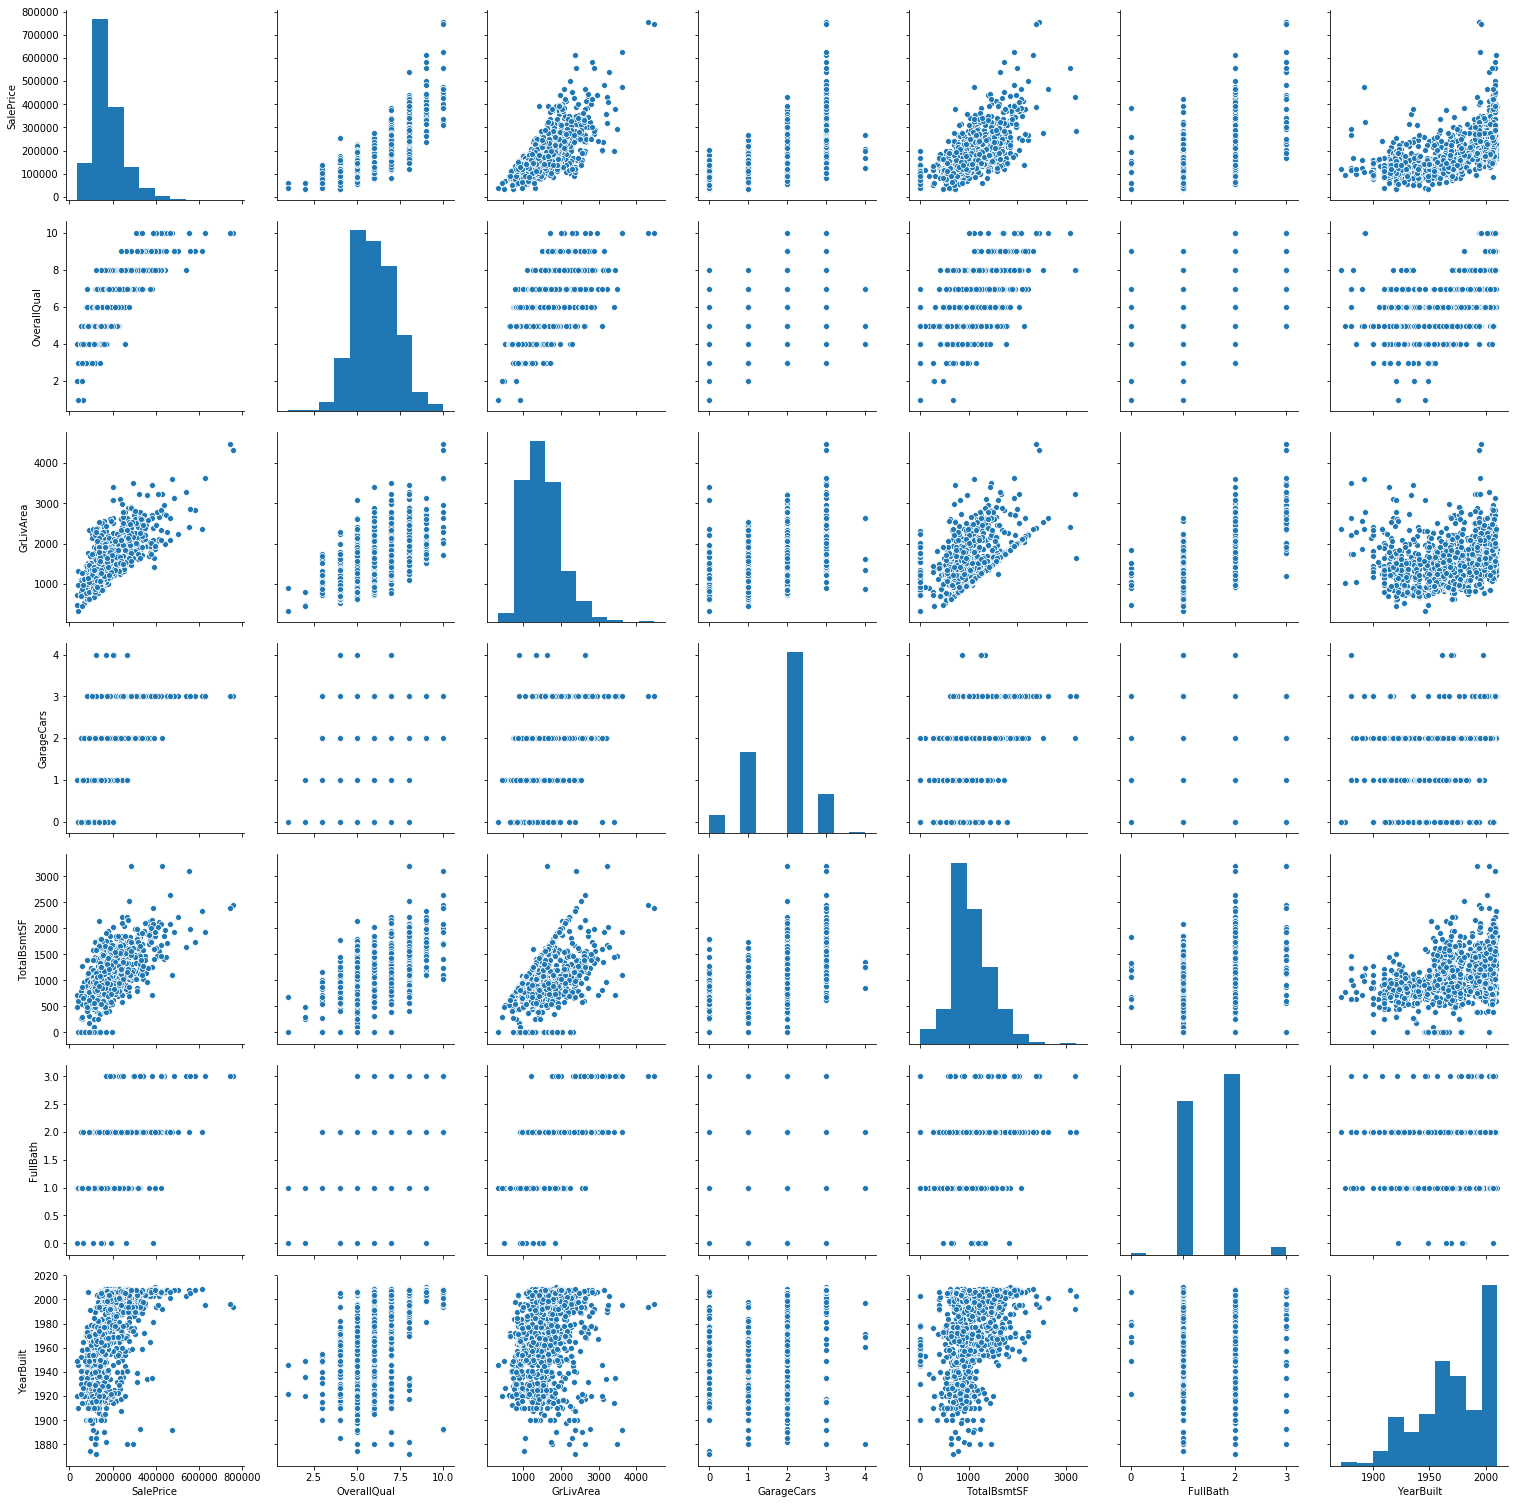

In [8]:
# Lets scatter plot between Saleprice and correlated values
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF','FullBath','YearBuilt'] # Rest ignored as they inter correlated with these features
sns.pairplot(train[cols],size=3)
plt.show()

### Target Value Transform..

Different features in the dataset may have have different ranges. For Ex, in our data set SalePrice column contains value in thousands and lakhs and YearBlt contains values in thousands. Thus which signifies that a column is more wighted as compared to other column.

 Value of miu : 180932.919 and Sigma : 79467.789


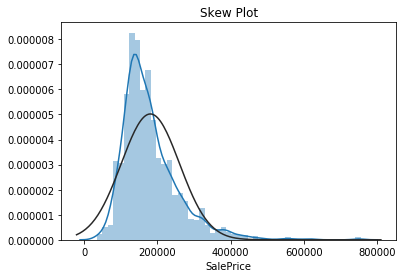

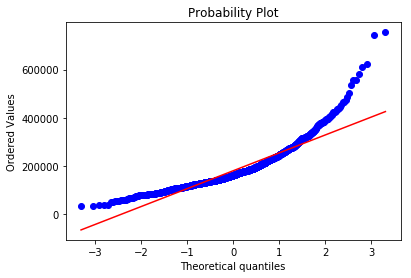

In [9]:
# Lets check skewness:
def check_skew(col):
    sns.distplot(train[col], fit= norm).set(title="Skew Plot")
    fig = plt.figure()
    res = stats.probplot(train[col], plot = plt)
    
    (miu, sigma) = norm.fit(train[col])
    print(' Value of miu : {:.3f} and Sigma : {:.3f}'.format(miu, sigma))
    
check_skew('SalePrice')

**We found that Our SalePrice colums is positively skewed**. As in figure SkewPlot black curve is deviated towards the right. So we need to fix it for improve performance of model

### Skewness can be fixed by ?

Best way is to perform a log transform on same data. With reduces the overall value of the data 

 Value of miu : 12.024 and Sigma : 0.400


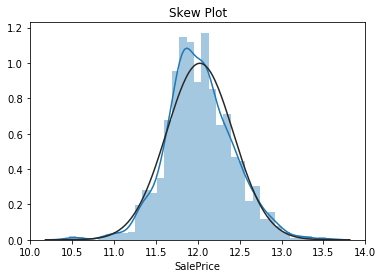

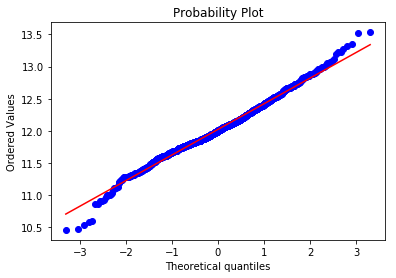

In [10]:
train['SalePrice']= np.log1p(train["SalePrice"])
# Numpy to the rescue

## Now lets check the skewness again
check_skew('SalePrice')

### Much better.

### After applying the Logarithm.

Cureve is now normally distributed. Suffiecient for now.

**Note: If we log the target variable. Then it is also require to log transform the skewed feature variables**

### Time for Feature Engineering


In [11]:
# lets add both train and test

ntrain = train.shape[0]
ntest = test.shape[0]

y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

print("all_data size is: {}".format(all_data.shape))

all_data size is: (2917, 79)


### Lets Visualize Missing Data


In [12]:
all_data_nan = (all_data.isnull().sum() / len(all_data) * 100)
all_data_nan = all_data_nan.drop(all_data_nan[all_data_nan==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing Ratio": all_data_nan})

[Text(0, 0.5, 'Percent of missing values'),
 Text(0.5, 0, 'Features'),
 Text(0.5, 1.0, 'Percent of missing data corresponding to features')]

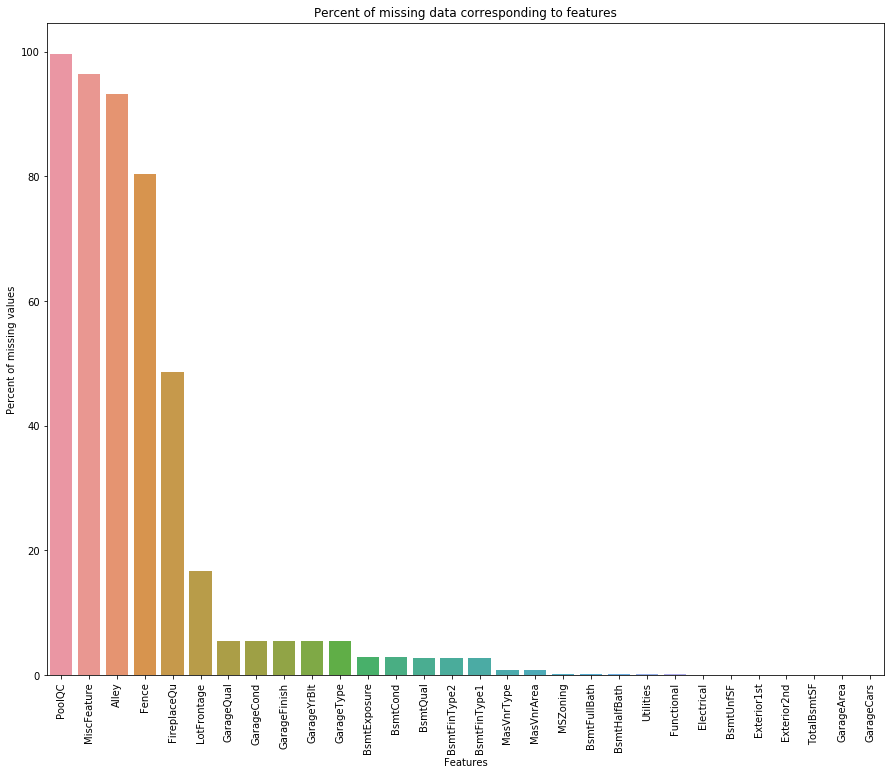

In [13]:
f, ax = plt.subplots(figsize=(15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_nan.index, y=all_data_nan)
ax.set(xlabel="Features",ylabel="Percent of missing values", title="Percent of missing data corresponding to features")

### Lets Handle missing data

In [14]:
# Replacing NaN in PoolQC data with None
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

# Replacing NaN in MiscFeature with None
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

# Replacing NaN in Alley with None
all_data["Alley"] = all_data["Alley"].fillna("None")

# Replacing NaN in Fence with None
all_data["Fence"] = all_data["Fence"].fillna("None")

# Replacing NaN in FireplaceQu with None
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

In [15]:
## Grouping by Neighborhood and LotFrontage.

group_df = all_data.groupby('Neighborhood')['LotFrontage']

for key, item in group_df:
    print(key,"\n")
    print(group_df.get_group(key))
    break

Blmngtn 

219     43.0
229     43.0
385     43.0
443     53.0
465      NaN
558      NaN
596     53.0
638     53.0
789     43.0
850      NaN
981     43.0
1003    43.0
1018    43.0
1022    43.0
1125    53.0
1392    53.0
1413    51.0
1481    43.0
1683    43.0
1982     NaN
1983     NaN
1984    53.0
2318     NaN
2319    53.0
2669    43.0
2670     NaN
2671     NaN
2672    43.0
Name: LotFrontage, dtype: float64


In [16]:
## Group By neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

In [17]:
## Quickly replacing NaN with None

for cols in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[cols] = all_data[cols].fillna('None')

In [18]:
# Replacing missing data with 0 in below

for cols in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[cols] = all_data[cols].fillna(0)
    
# Replace missing data with None on below
for cols in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[cols] = all_data[cols].fillna('None')

all_data['MasVnrType'] = all_data['MasVnrType'].fillna("None")
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

In [19]:
# MSZoning is general Zoning classification

all_data['MSZoning'].value_counts()

RL         2263
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

In [20]:
# As RL is the most common value i.e the mode.
# So it can be replaced with RL

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])


In [21]:
# Lets see Utilities
all_data['Utilities'].value_counts()

AllPub    2914
NoSeWa       1
Name: Utilities, dtype: int64

In [22]:
# Here most of the values belongs to one category. So 
# We can just drop this.
all_data = all_data.drop(['Utilities'], axis=1)


In [23]:
## Functional 
all_data["Functional"] = all_data["Functional"].fillna("Typ")


In [24]:
## Below colums contains categorical value. 
## So it is better to just replace it with mode of the columns

mode_cols = ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for cols in mode_cols:
    all_data[cols] = all_data[cols].fillna(all_data[cols].mode()[0])

In [25]:
## MSSubClass 

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [26]:
## Lets check again if any missing value left to handle

all_data_nan = (all_data.isnull().sum()/len(all_data) * 100)
all_data_nan = all_data_nan.drop(all_data_nan[all_data_nan == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Rating': all_data_nan})
missing_data.head()

,Missing Rating


### All Missing Values are handled

## Now there are many features that contains continous values but they are actually categorical


In [27]:
all_data['OverallCond'].value_counts()


5    1643
6     531
7     390
8     144
4     101
3      50
9      41
2      10
1       7
Name: OverallCond, dtype: int64

In [28]:
## Converting numerical to string type
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

### Label Encoding above strings


In [29]:
from sklearn.preprocessing import LabelEncoder

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
for col in cols:
    label = LabelEncoder()
    label.fit(list(all_data[col].values))
    all_data[col] = label.transform(list(all_data[col].values))
    

# Shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


#### Little bit feature engineering

In [30]:
all_data['TotalSqFoot'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### Earlier we check skewness on target variable
#### Now check skewnes on features

In [31]:
numerical_features = all_data.dtypes[all_data.dtypes != 'object'].index

# Check the skew of a numerical features

skewed_features = all_data[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)

# List of skewness in numerical features
print("Skew in numerical features:")
skewness = pd.DataFrame({'Skew': skewed_features})

skewness.head(20)

Skew in numerical features:


,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [32]:
# Now Box Cox transformation of Highly skewed features data
skewness = skewness[abs(skewness)>0.75]
print("There are {} skewed numerical features to Box Cox transform........".format(skewness.shape[0]))

# Scipy comes handy
from scipy.special import boxcox1p

skewed_features = skewness.index

lamda = 0.15

for features in skewed_features:
    all_data[features] = boxcox1p(all_data[features], lamda)

There are 59 skewed numerical features to Box Cox transform........


#### Getting dummy categorical values

In [33]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

In [34]:
# Train and Test Data Creation

train = all_data[:ntrain]
test = all_data[ntrain:]

train.shape

(1458, 220)

### Get into modelling

In [35]:
# Importing Libraries
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### Cross Validation

In [36]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [37]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)



In [38]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 0.1115 (0.0074)



In [39]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



### Gradient Boosting

In [40]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1177 (0.0080)



### Lets fit 

In [41]:
LassoMd = lasso.fit(train.values,y_train)
ENetMd = ENet.fit(train.values,y_train)
KRRMd = KRR.fit(train.values,y_train)
GBoostMd = GBoost.fit(train.values,y_train)

In [43]:
finalMd = (np.expm1(LassoMd.predict(test.values)) + np.expm1(ENetMd.predict(test.values)) + np.expm1(KRRMd.predict(test.values)) + np.expm1(GBoostMd.predict(test.values)) ) / 4
finalMd

array([120177.72631583, 163816.91476834, 183417.48473384, ...,
       171142.0334803 , 114284.70143214, 222131.78687063])

### Submission File

In [45]:
sub = pd.DataFrame()
sub['Id'] = test_id
sub['SalePrice'] = finalMd
sub.to_csv('submission.csv',index=False)